# Sliding Window And GAN for Explainability (SWAGE)

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm

In [2]:
%matplotlib notebook

## Change code below to incorporate your *model* and *input processing*

### Define your model here:

In [3]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K

Using TensorFlow backend.


In [4]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

### Load and preprocess image

In [5]:
from keras.preprocessing import image

In [6]:
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [7]:
image.load_img

<function keras_preprocessing.image.utils.load_img(path, grayscale=False, color_mode='rgb', target_size=None, interpolation='nearest')>

---

## SWAGE + RISE (for comparison)

In [8]:
def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array(model.input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model.input_size[0], y:y + model.input_size[1]]
    masks = masks.reshape(-1, *model.input_size, 1)
    
    return masks

In [33]:
batch_size = 100

def explain(model, inp, masks, N):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    # 2nd iteration
#     masks = sliding_mask()
#     print(np.argmax(preds, axis=1))
    print(preds.shape)
#     print(masks.shape)
#     print(*model.input_size)
#     print(N,-1)
    print(masks.reshape(N, -1).shape)
    print(preds.T.dot(masks.reshape(N, -1)).shape)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    print(sal.shape)
    sal = sal / N / p1
    return sal

In [25]:
def sliding_mask(inp):
    inp = inp[0]
    masked = []
    stepSize = 20
    (w_width, w_height) = (100, 100) # window size
    for x in range(0, inp.shape[1] - int(w_width/4) , stepSize):
        for y in range(0, inp.shape[0] - int(w_height/4), stepSize):
            mask = np.zeros((inp.shape[0], inp.shape[1]))
            mask[x:x + w_width, y:y + w_height] = 1
#             mask = np.resize(mask, inp.shape)
#             plt.figure()
#             plt.imshow(mask)
            masked.append(mask)
    masked = np.array(masked)
    masks = masked.reshape(-1, *model.input_size, 1)
    
    return masks.shape[0], masks

---

## Running explanations

In [11]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

In [12]:
model = Model()

Instructions for updating:
Colocations handled automatically by placer.


In [34]:
img, x = load_img('broccoli1.png')

In [35]:
N_rise = 2000
s = 8
p1 = 0.5
masks_rise = generate_masks(2000, 8, 0.5)

Generating masks: 100%|██████████| 2000/2000 [00:05<00:00, 334.14it/s]


In [36]:
s = 8
p1 = 0.5
N_swage, masks_swage = sliding_mask(x)

In [37]:
sal_swage = explain(model, x, masks_swage, N_swage)

Explaining: 100%|██████████| 1/1 [00:08<00:00,  8.91s/it]


(100, 1000)
(100, 50176)
(1000, 50176)
(1000, 224, 224)


In [17]:
sal_rise = explain(model, x, masks_rise, N_rise)

Explaining: 100%|██████████| 20/20 [03:11<00:00,  9.70s/it]


[937   1 937 ... 937 937 937]
(2000, 1000)
(2000, 224, 224, 1)
224 224
2000 -1
(2000, 50176)
(1000, 50176)
(1000, 224, 224)


<IPython.core.display.Javascript object>


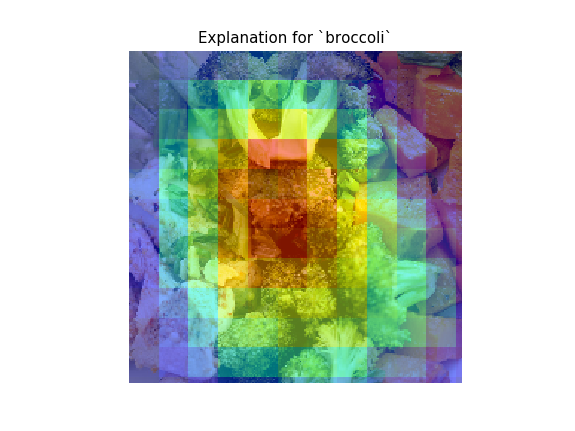

In [30]:

class_idx = 937
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
plt.imshow(sal_swage[class_idx], cmap='jet', alpha=0.5)
# plt.colorbar()
plt.show()

In [19]:
masks_swage.shape

(16, 224, 224, 1)

In [23]:
class_idx = 937
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
plt.imshow(sal_rise[class_idx], cmap='jet', alpha=0.5)
# plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


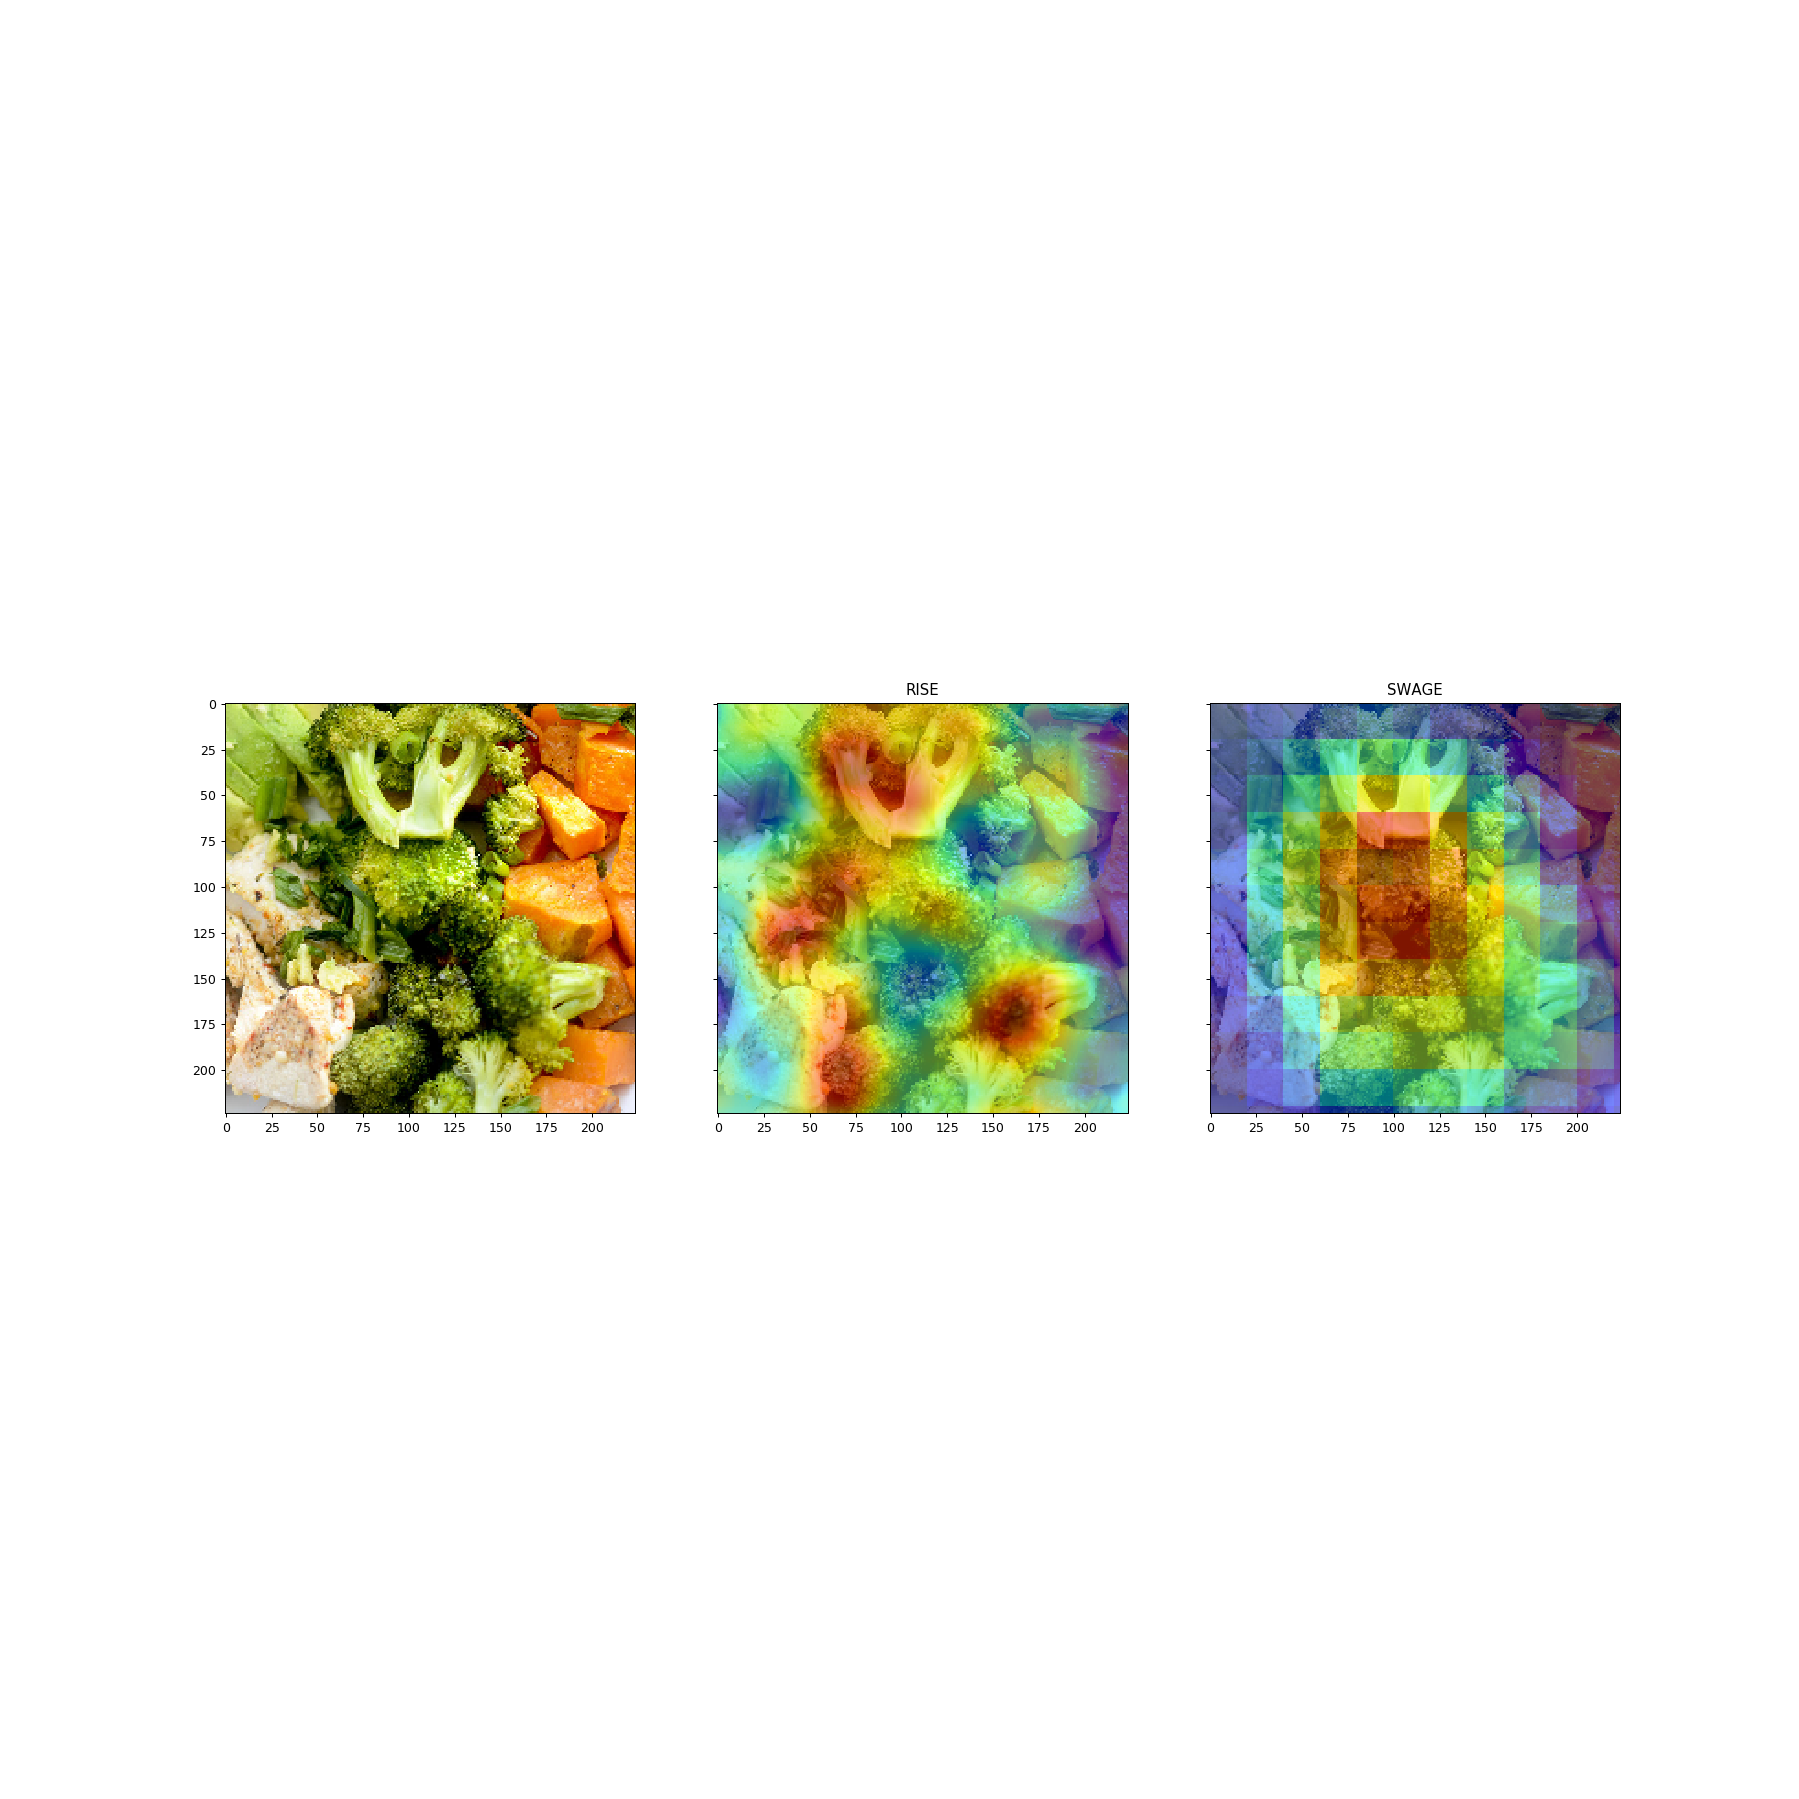

In [31]:
class_idx = 937
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='row', figsize=(20,20))

ax1.imshow(img)

ax2.imshow(img)
ax2.imshow(sal_rise[class_idx], cmap='jet', alpha=0.5)
ax2.set_title('RISE')
# 2nd suplot
ax3.imshow(img)
ax3.imshow(sal_swage[class_idx], cmap='jet', alpha=0.5)
ax3.set_title('SWAGE')

plt.savefig('explain-broccoli-sliding-window.png')

In [76]:
masked = true*masks

masked.shape

(2000, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


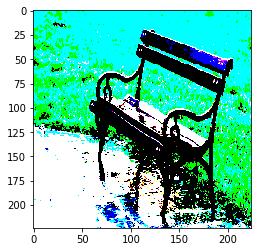

In [49]:
plt.imshow(x.reshape(224,224,3))

TypeError: Invalid dimensions for image data

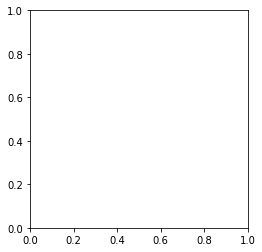

In [51]:

m = masks[9]
m = (m + 1.)/2
plt.imshow(m)
plt.axis('on')
plt.show()